# Exploring Fraud Detection With Neo4j & Graph Data Science
#### __*Hands on Examples with Peer-to-Peer (P2P) Data*__

### TOC:
* [Notebook Setup](#p0)
* [PART 1: Exploring the Data](#p1)
* [PART 2: Resolving Fraud Communities with Entity Resolution and Community Detection](#p2)
* [PART 3: Identifying Suspicious Accounts With Centrality & Node Similarity](#p3)
* [PART 4: Predicting Fraud Risk Accounts with Machine Learning](#p4)


## Notebook Setup <a name="p0"></a>

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>
```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [2]:
NEO4J_PROPERTIES_FILE = '/Users/zachblumenfeld/devtools/auth/aura-p2p-fd.ini'

In [3]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Using custom database properties


In [4]:
driver = GraphDatabase.driver(HOST, auth=(USERNAME, PASSWORD))

### Helper Functions

In [5]:
def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

def clear_graph(driver, graph_name):
    if run(driver, f"CALL gds.graph.exists('{graph_name}') YIELD exists RETURN exists")[0].get("exists"):
        run(driver, f"CALL gds.graph.drop('{graph_name}')")

def clear_all_graphs(driver):
    graphs = run(driver, 'CALL gds.graph.list() YIELD graphName RETURN collect(graphName) as graphs')[0].get('graphs')
    for g in graphs:
        run(driver, f"CALL gds.graph.drop('{g}')")

def identifier_degrees(user_label, degree_property):
    params = {'userLabel': user_label, 'property': degree_property}
    clear_graph(driver, 'id-projection')
    run(driver, '''
        CALL gds.graph.create('id-projection',
            [$userLabel, 'Card', 'Device', 'IP'],
            {
                HAS_CC: {orientation: 'REVERSE'},
                HAS_IP: {orientation: 'REVERSE'},
                USED: {orientation: 'REVERSE'}
            }
        )
    ''', params=params)

    run(driver, '''
        CALL gds.degree.mutate('id-projection', {
            mutateProperty: $property
        })
    ''', params=params)

    run(driver, '''
        CALL gds.graph.writeNodeProperties('id-projection',
            [$property],
            ['Card', 'Device', 'IP']
        )
    ''', params=params)
    clear_graph(driver, 'id-projection')

## PART 1: Exploring the Data <a name="p1"></a>

### A Bit About the Data

This is an anonymized sample of user accounts and transactions from a real-world P2P platform.  All user information and identifiers have been anonymized, exact duplicate values are maintained per the process described here.

Below is the graph schema for the anonymized data sample.


<img src="img/schema.png" width="500" >

In this anonymized version of the dataset P2P transactions are represented by relationships going from the sender to recipient user. We are disclosing 3 identifier nodes for Users.  Credit Cards, Devices, and IP Addresses. Users can also refer other Users onto the platform though this is sparsely present in the dataset and not leveraged in our analysis.

Each User node has an indicator variable for MoneyTransfer fraud (1 for known fraud and 0 otherwise). This indicator is determined by a combination of credit card chargeback events and manual review. A chargeback is an action taken by a bank to reverse electronic payments. It involves reversing a payment and triggering a dispute resolution process, often for billing errors and unauthorized credit use. In short, a user must have at least one chargeback to be considered fraudulent. Only a small proportion of the users, roughly 0.7%, are flagged for fraud.


Below is a breakdown of high-level counts by labels and relationships as well as the flagged accounts.

In [6]:
# total node counts
result = run(driver, 'CALL apoc.meta.stats() YIELD labels AS nodeCounts')
pd.DataFrame(dict(result[0])).transpose()

,Card,Device,FraudRiskUser,FraudSharedId,IP,User
nodeCounts,118818,51451,452,18182,585855,33732


In [7]:
# total relationship counts
result = run(driver, 'CALL apoc.meta.stats() YIELD relTypesCount as relationshipCounts')
pd.DataFrame(dict(result[0])).transpose()

,HAS_CC,HAS_IP,P2P,REFERRED,USED
relationshipCounts,132030,1511152,110372,1901,56013


In [8]:
result = run(driver, 'MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraudMoneyTransfer, count(u) AS cnt')
pd.DataFrame(dict(record) for record in result)

,fraudMoneyTransfer,cnt
0,0,33491
1,1,241


### A Closer Look at Fraud

#### Evaluating Cards and Devices

Upon an initial investigation of aggregate statistics, the labeled fraud accounts do not look well connected which would naturally make one skeptical of a graph based approach.  This is exemplified well by the lack of discrimination in key identifiers.

As a first step, I broke out the ratio of fraud vs non-fraud users connected to credit cards and devices to find that very few cards or devices are centered well around flagged accounts. This is a bit surprising for me. If a card or device is used by a flagged account, I would expect the other accounts that use the card/device to also be mostly flagged for fraud as well.

In [9]:
# Setting a label for flagged users will enable faster lookups in cypher and faster gds projections
run(driver, 'MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

[<Record count(u)=241>]

In [10]:
# Use GDS degree centrality to count the number of Users connected to each identifier type - Card, Device, IP
identifier_degrees('User', 'degree')
# Use GDS degree centrality to count the number of FLAGGED Users connected to each identifier type - Card, Device, IP
identifier_degrees('FlaggedUser', 'flaggedDegree')

# Calculate the ratio of flagged users to total users
run(driver, '''
        MATCH(n) WHERE n:Card OR n:Device OR n:IP
        SET n.flaggedRatio = toFloat(n.flaggedDegree)/toFloat(n.degree)
''')

[]

In [11]:
result = run(driver, '''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    RETURN flaggedUserRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount ORDER BY flaggedUserRatio
''')
print('Flagged User Ratio for Card Count')
pd.DataFrame([dict(record) for record in result])

Flagged User Ratio for Card Count


,flaggedUserRatio,count,percentCount
0,0,8185,0.964
1,1,31,0.004
2,Between 0-1,274,0.032


In [12]:
result = run(driver, '''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    RETURN flaggedUserRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount ORDER BY flaggedUserRatio
''')
print('Flagged User Ratio for Device Count')
pd.DataFrame([dict(record) for record in result])

Flagged User Ratio for Device Count


,flaggedUserRatio,count,percentCount
0,0,2655,0.967
1,1,2,0.001
2,Between 0-1,88,0.032


The above distributions suggest that cards and devices with some flagged users rarely belong solely to flagged users, which in the context of fraud rings is a bit surprising to me.

#### Exploring Potential Fraud Patterns with Community Detection

In this example, it is unclear to me what exactly is taking place, and I have a hunch that the fraud activity is not completely labeled given the lack of connectivity and the limited chargeback logic used to flag fraud. At the same time I do not want to simply label every user that shares a card or device with another flagged account since it is possible that a benign user’s device and or card was used fraudulently by another. Since fraudsters are actively avoiding being identified, actors committing fraud are often not just represented by a single user account, but rather by multiple accounts and identifiers which, hopefully for us, share some connections and similarities.

In a graph, we can attempt to roughly identify these fragmented identities with Community Detection, a large set of methods that attempt to partition graphs into well connected groups a.k.a. Communities, where the connectivity in the communities is significantly higher than outside the community. There are multiple forms of community detection, we will use a couple in this post, starting with Louvain.

#### Using Louvain Community Detection

Louvain is useful for exploratory analysis of communities because it uses a form of modularity scoring to split up the graph into hierarchical communities, which means that your graph structure doesn’t need to be exact for it to provide informative communities.

I will leverage P2P transactions, cards, and devices for Louvain. We will leave out IP addresses for now, since they have some super node issues. Once Louvain has run, we can order communities by the count of flagged users and examine some of the more concentrated flagged communities. The code for running Louvain is here.


In [13]:
clear_graph(driver,'comm-projection')

run(driver, '''
    CALL gds.graph.create('comm-projection', ['User','Card', 'Device'], {
        HAS_CC: {orientation: 'UNDIRECTED'},
        USED: {orientation: 'UNDIRECTED'},
        P2P: {orientation: 'NATURAL', aggregation: 'SINGLE'}
        }
    )
''')

run(driver, '''
    CALL gds.louvain.write('comm-projection', {
            writeProperty: 'louvainCommunityId'
    })
''')

[<Record writeMillis=483 nodePropertiesWritten=204001 modularity=0.9683415433169338 modularities=[0.8466185078256645, 0.9534697165201068, 0.9683415433169338] ranLevels=3 communityCount=13614 communityDistribution={'p99': 89, 'min': 1, 'max': 3539, 'mean': 14.984648156309682, 'p90': 26, 'p50': 10, 'p999': 421, 'p95': 36, 'p75': 16} postProcessingMillis=74 preProcessingMillis=0 computeMillis=3115 configuration={'maxIterations': 10, 'writeConcurrency': 4, 'seedProperty': None, 'consecutiveIds': False, 'maxLevels': 10, 'relationshipWeightProperty': None, 'concurrency': 4, 'writeProperty': 'louvainCommunityId', 'includeIntermediateCommunities': False, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'tolerance': 0.0001, 'username': None}>]

In [14]:
result  = run(driver, '''
    MATCH (u:User)
    WITH u.louvainCommunityId AS community, count(u) AS cnt, sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN community, cnt, flaggedCount, toFloat(flaggedCount)/toFloat(cnt) AS flaggedRatio ORDER BY flaggedCount DESC LIMIT 100
''')
print("Louvain Communities Ordered by count of Flagged Users")
pd.DataFrame([dict(record) for record in result])

Louvain Communities Ordered by count of Flagged Users


,community,cnt,flaggedCount,flaggedRatio
0,195231,40,6,0.150000
1,181293,7,4,0.571429
2,35239,7,3,0.428571
3,188313,6,3,0.500000
4,176956,3,3,1.000000
...,...,...,...,...
95,157850,5,1,0.200000
96,12296,4,1,0.250000
97,200028,5,1,0.200000
98,170483,1,1,1.000000


We can view communities of users and connecting identifiers in Neo4j Bloom or Browser with queries of the form:

```cypher
MATCH(u1:User{louvainCommunityId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{louvainCommunityId: $id})
WITH *
OPTIONAL MATCH (u1)-[:P2P]-(u2)
RETURN *
```
If we take a look at communities with flag users, we will see an interesting pattern of those flagged users sending money to other accounts with which they share devices, cards, and IPs. This behavior is suspicious because it suggests that the same individual or group of individuals may be using multiple accounts to withdraw cash from credit transactions prior to a chargeback being executed on the cards. The shared credit card examples (such as example 2 below) are some of the most indicative.

Example 1:
<img src="img/louvain-community-11.png" width="900" >

Example 2:
<img src="img/louvain-community-12.png" width="900" >

This pattern indicates that the receiving user accounts are fraud risk accounts. In the next section we will use these patterns to inform resolution of fraud communities and the labeling of additional fraud risk accounts.

## PART 2: Resolving Fraud Communities with Entity Resolution and Community Detection <a name="p2"></a>

Identifying communities that reflect underlying groups of individuals is often a key step to fraud detection.  We already explored with Louvain; in this section, we will provide more formal definitions for resolving entities that will allow us to create well defined communities in a scalable manner.

To accomplish this, we will define some Entity Resolution (ER) rules that will allow us to draw relationships between users which we believe belong to the same underlying community, we will then use the Weakly Connected Components (WCC) algorithm to resolve the communities,  lastly, we will label all users in communities that include flagged accounts as fraud risks.

### Entity Resolution Business Rules

We will now use Entity Resolution (ER) to resolve groups of individuals behind sets of user accounts. For this analysis, we will use some pretty straightforward ER business logic. If either of the two below conditions are true, we will resolve two user accounts by linking them together with a new relationship type.

1. One user sent money to another user that shares the same credit card
2. Two users share a card or device connected to less than or equal to 10 total accounts, and those two users also share at least two other identifiers of type credit card, device, or IP address

You could switch out or add different rules to the above, these are just examples. In a real-world scenario these business rules would pass by SMEs and possibly be backed by further supervised machine learning on manually labeled data.

For a P2P dataset, we do not necessarily want to label all senders/receivers of flagged user transactions as fraudulent since some fraud schemes involve transactions with victims. Furthermore, additional identifiers such as IP may be inexact and cards + devices can be fraudulently controlled/used without the owners permission. Hence I used somewhat stringent rules that aligned with the patterns noted in part 1. We can apply relationships to reflect these business rules using cypher:


In [15]:
# P2P with shared card rule
run(driver, '''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

[<Record cnt=6240>]

In [16]:
# Shared ids rule
run(driver, '''
    MATCH (u1:User)-[:HAS_CC|USED]->(n)<-[:HAS_CC|USED]-(u2)
    WHERE n.degree <= 10 AND id(u1) < id(u2)
    WITH u1, u2, count(DISTINCT n) as cnt
    MATCH (u1)-[:HAS_CC|USED|HAS_IP]->(m)<-[:HAS_CC|USED|HAS_IP]-(u2)
    WITH u1, u2, count(DISTINCT m) as cnt
    WHERE cnt > 2
    MERGE(u1)-[s:SHARED_IDS]->(u2)
    RETURN count(DISTINCT s)
''')

[<Record count(DISTINCT s)=5316>]

### Using Weakly Connected Components (WCC) to Resolve Communities

Weakly Connected Components (WCC) is a simple yet practical community detection algorithm that connects all nodes by a set of relationships in the graph. WCC is highly scalable and unlike other community detection algorithms such as Louvain and LPA, it is easily explainable and transparent - A node is included in a community if and only if there is a connecting path from that node to the community using the provided set of node and relationship filters. This makes WCC a good choice for formal community detection in production fraud detection settings.

Below we run WCC on users via the relationships created above:


In [17]:
clear_graph(driver, 'comm-projection')
run(driver, '''
    CALL gds.graph.create('comm-projection',
        ['User'],
        {
            SHARED_IDS: {orientation: 'UNDIRECTED'},
            P2P_WITH_SHARED_CARD: {orientation: 'UNDIRECTED'}
        }
    )
''')

run(driver, '''
    CALL gds.wcc.write('comm-projection', {
        writeProperty: 'wccId'
    }) YIELD writeMillis, nodePropertiesWritten, componentCount, componentDistribution
''')

[<Record writeMillis=104 nodePropertiesWritten=33732 componentCount=28203 componentDistribution={'p99': 3, 'min': 1, 'max': 175, 'mean': 1.196042974151686, 'p90': 2, 'p50': 1, 'p999': 8, 'p95': 2, 'p75': 1}>]

### Labeling Fraud Risk User Accounts

As these communities are meant to label underlying groups of individuals, if even one flagged account is in the community, we will label all user accounts in the group as fraud risks:


In [18]:
run(driver, '''
    MATCH (f:FlaggedUser)
    WITH collect(DISTINCT f.wccId) AS flaggedCommunities
    MATCH(u:User) WHERE u.wccId IN flaggedCommunities
    SET u:FraudRiskUser
    SET u.fraudRisk=1
    RETURN count(u)
''')

[<Record count(u)=452>]

In [19]:
run(driver, '''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
    RETURN count(u)
''')

[<Record count(u)=33280>]

### WCC Community Statistics

The breakdown of communities by size is listed below. The majority are single user communities. Only a small portion have multiple users and of those, community sizes are mostly 2 and 3. Larger communities are rare.  However, if we look at the fraudUser accounts we will see that the majority reside in multi-user communities.  The 118 fraud accounts in single user communities are flagged users (via original chargeback logic) that have yet to be resolved.

In [20]:
result = run(driver, '''
    MATCH (u:User)
    WITH u.wccId AS community, count(u) AS cSize, sum(u.fraudRisk) AS cFraudSize
    WITH community, cSize, cFraudSize,
    CASE
        WHEN cSize=1 THEN ' 1'
        WHEN cSize=2 THEN ' 2'
        WHEN cSize=3 THEN ' 3'
        WHEN cSize>3 AND cSize<=10 THEN ' 4-10'
        WHEN cSize>10 AND cSize<=50 THEN '11-50'
        WHEN cSize>10 THEN '>50' END AS componentSize
    RETURN componentSize, count(*) as numberOfComponents, sum(cSize) AS totalUserCount, sum(cFraudSize) AS fraudUserCount ORDER BY componentSize
''')
pd.DataFrame([dict(record) for record in result])

,componentSize,numberOfComponents,totalUserCount,fraudUserCount
0,1,24283,24283,118
1,2,3165,6330,144
2,3,481,1443,63
3,4-10,258,1246,68
4,11-50,15,255,59
5,>50,1,175,0


Similar to Louvain we can view communities of users and connecting identifiers in Neo4j Bloom or Browser with queries of the form:

```cypher
MATCH(u1:User{wccId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{wccId: $id})
WITH *
OPTIONAL MATCH (u1)-[r3:P2P]-(u2)
RETURN *
```

Example 1:
<img src="img/wcc-community-12.png" width="900" >

Example 2:
<img src="img/wcc-community-11.png" width="900" >

### Outcomes of Fraud Risk Labeling
Fraud Risk labeling helped identify an additional 211 new fraud risk user accounts, nearly doubling the number of known fraud users (87.5% increase). We also see that 65% of the money going to/from previously flagged accounts and other users can be attributed to the newly identified risk accounts:

In [21]:
run(driver, '''
   MATCH (:FlaggedUser)-[r:P2P]-(u)  WHERE NOT u:FlaggedUser
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-(:FlaggedUser) WHERE NOT u:FlaggedUser
   WITH p2pTotal,  toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''')[0].get('p')

0.652

Additionally, while the newly identified 211 accounts represents less than 1% of total users in the sample, 12.7% of the total P2P amount in the sample involved the newly identified accounts as senders or receivers:

In [22]:
run(driver, '''
   MATCH (:User)-[r:P2P]->()
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-() WHERE NOT u:FlaggedUser
   WITH p2pTotal, toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''')

[<Record p=0.127>]

Finally, we can see an improvement in card and device discrimination with many more cards and devices being used by fraud risk accounts exclusively.

In [23]:
identifier_degrees('FraudRiskUser', 'fraudRiskDegree')

run(driver, '''
        MATCH(n) WHERE n:Card OR n:Device OR n:IP
        SET n.fraudRiskRatio = toFloat(n.fraudRiskDegree)/toFloat(n.degree)
''')

[]

In [24]:
result = run(driver, '''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    RETURN fraudRiskRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount ORDER BY fraudRiskRatio
''')
pd.DataFrame([dict(record) for record in result])

,fraudRiskRatio,count,percentCount
0,0,8114,0.956
1,1,351,0.041
2,Between 0-1,25,0.003


In [25]:
result = run(driver, '''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    RETURN fraudRiskRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount ORDER BY fraudRiskRatio
''')
pd.DataFrame([dict(record) for record in result])

,fraudRiskRatio,count,percentCount
0,0,2605,0.949
1,1,92,0.034
2,Between 0-1,48,0.017


The aggregate P2P statistics combined with improvements in Card and Device metrics are significant given the limited scope of the previously flagged fraud which focused on chargebacks.  These results strongly imply that there are more sophisticated networks of fraudulent money flows behind the chargebacks rather than the chargebacks being isolated occurrences.

## PART 3: Identifying Suspicious Accounts With Centrality & Node Similarity <a name="p3"></a>

In parts 1 & 2 we explored the graph and identified high risk fraud communities. At this stage, we may want to expand beyond our business logic to automatically identify other users that are suspiciously similar to the fraud risks already identified. Neo4j and GDS makes it simple to triage and recommend such suspect users in a matter of seconds. We can leverage both centrality and similarity algorithms for this.


### Using Weighted Degree Centrality to Recommend Potential High Risk Accounts

We can quickly and easily generate a ranked list of suspicious user accounts with weighted degree centrality. Specifically, we can calculate the degree centrality of users in respect to their identifiers (Devices, Cards, and IPs) weighted by the fraudRiskRatios we made in part 2. In this case, a simple Cypher query suffices.


In [26]:
result = run(driver,'''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(u:User)-[:HAS_CC|HAS_IP|USED]->(n) WHERE NOT u:FraudRiskUser
    WITH left(u.guid,8) as uid,
        sum(n.fraudRiskRatio) AS totalIdFraudRisk,
        count(n) AS numberFraudRiskIds
    WITH uid, totalIdFraudRisk,
        numberFraudRiskIds,
        totalIdFraudRisk/toFloat(numberFraudRiskIds) AS averageFraudIdRisk
    WHERE averageFraudIdRisk >= 0.25
    RETURN uid, totalIdFraudRisk, numberFraudRiskIds, averageFraudIdRisk
    ORDER BY totalIdFraudRisk DESC LIMIT 10
''')

pd.DataFrame([dict(record) for record in result])

,uid,totalIdFraudRisk,numberFraudRiskIds,averageFraudIdRisk
0,50fd11c0,7.405512,28,0.264483
1,b41b9e3b,6.487978,22,0.294908
2,a982e8fc,3.928543,13,0.302196
3,60b71ab9,2.020481,7,0.288640
4,bc1eb835,2.010309,5,0.402062
5,1b1a78a9,1.925455,5,0.385091
6,f2b8a068,1.693794,6,0.282299
7,1c773976,1.594978,5,0.318996
8,a2f748e3,1.570455,4,0.392614
9,7524a090,1.527338,5,0.305468


Users in the above result list are sorted by how much identifying information they share with previously labeled fraud risks, the ones with the most being at the top. Technically speaking, these users are ranked by their total Id fraud risk, which is equal to the sum of the fraudRiskRatios from the Identifiers they are connected to. In the query I also implement a limit on the average fraud risk to avoid users that just have a lot of high-degree identifiers (likely proxy ip addresses shared by only a small fraction of fraud risk users). This sort of filtering can be tweaked by use case to get the right balance between total risk vs average risk.

In a real-world fraud detection use case, these results can be triaged by analysts to label more fraud accounts and grow labeled fraud communities.

### Using Node Similarity to Expand on Fraud Communities

Simple calculations like weighted degree centrality work well for identifying suspicious users over the whole graph, but what if we are interested in how users are related to a specific fraud risk community or set of communities? Perhaps we hypothesize that communities of fraud risk users are actually bigger than currently represented but we don’t have exact business rules to apply. We can leverage similarity algorithms to help us score and recommend users for this.

GDS offers multiple algorithms for similarity. In this analysis I will focus on the aptly named  Node Similarity algorithm – you can read more about it [here](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/). Node similarity parallelizes well and is explainable. It identifies pairs of similar nodes based on a straightforward Jaccard similarity calculation. So while other ML-based similarity approaches like FastRP + KNN covered [in this post](https://neo4j.com/developer-blog/exploring-practical-recommendation-systems-in-neo4j/) scale well for running globally on very large graphs, Node Similarity is a good choice where explainability is important and you can narrow down the universe of comparisons to a subset of your data. Examples of narrowing down include focusing on just single communities, newly added users, or users within a specific proximity to suspect accounts. In this analysis we will take the third approach, filtering to just those Cards, Devices, and IP addresses that connect to at least one fraud risk account from part 2.


Below I apply three queries to calculate node similarity for Users based on shared Card, Device, and IP addresses. The first query accomplishes the identifier filtering via setting a new label. The first query also weights relationships by the inverse of degree centrality, essentially downplaying the importance of identifiers proportional to the number of other users they connect to. This is important as some identifiers, particularly IP addresses, can connect to hundreds or thousands of users, in which case the identifier may be very generic (like a proxy IP address) and not as relevant to true user identity. The second and third query project the graph and write relationships back to the database with a score to represent similarity strength between user node pairs. You will notice that I use a similarity cutoff of 0.01 in the third query, which is intended to rule out weak associations and keep the similarities relevant.


In [27]:
# label identifiers and users that are close to fraud risk users and assign inverse degree weight
run(driver,'''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(n)<-[r:HAS_CC|HAS_IP|USED]-(u)
    SET n:FraudSharedId
    SET r.inverseDegreeWeight = 1.0/(n.degree-1.0)
    RETURN count(DISTINCT n)
''')

[<Record count(DISTINCT n)=18182>]

In [28]:
clear_graph(driver, 'similarity-projection')
run(driver, '''
    CALL gds.graph.create('similarity-projection',
        ['User', 'FraudSharedId'],
        ['HAS_CC', 'USED', 'HAS_IP'],
        {relationshipProperties: ['inverseDegreeWeight']}
    ) YIELD nodeCount, relationshipCount, createMillis
''')

[<Record nodeCount=51914 relationshipCount=692806 createMillis=425>]

In [29]:
run(driver, '''
    CALL gds.nodeSimilarity.write('similarity-projection',{
        writeRelationshipType: 'SIMILAR_IDS',
        writeProperty: 'score',
        similarityCutoff: 0.01,
        relationshipWeightProperty: 'inverseDegreeWeight'
    }) YIELD computeMillis, writeMillis, relationshipsWritten, similarityDistribution
''')

[<Record computeMillis=76164 writeMillis=8618 relationshipsWritten=314488 similarityDistribution={'p1': 0.023890316486358643, 'max': 1.0000075697898865, 'p5': 0.06617635488510132, 'p90': 0.5132293105125427, 'p50': 0.18832391500473022, 'p95': 0.8225058913230896, 'p10': 0.08744043111801147, 'p75': 0.31004709005355835, 'p99': 1.0000075697898865, 'p25': 0.12365764379501343, 'p100': 1.0000075697898865, 'min': 0.010002970695495605, 'mean': 0.25994297649439113, 'stdDev': 0.21765678101688074}>]

From here, we can run a Cypher query to rank users by how similar they are to known fraud risk communities.

In [30]:
#get nodes similar to the high risk ones
result = run(driver, '''
    MATCH (f:FraudRiskUser)
    WITH f.wccId AS componentId, count(*) AS numberOfUsers, collect(f) AS users
    UNWIND users AS f
    MATCH (f)-[s:SIMILAR_IDS]->(u:User) WHERE NOT u:FraudRiskUser AND numberOfUsers > 2
    RETURN u.guid AS userId, sum(s.score) AS totalScore, collect(DISTINCT componentId) AS closeToCommunityIds ORDER BY totalScore DESC
''')
pd.DataFrame([dict(record) for record in result])

,userId,totalScore,closeToCommunityIds
0,0b3f278ff6b348fb1a599479d9321cd9,0.427332,"[4616, 4932]"
1,c0d80bb57c0bbb0b68f647c7adc83274,0.298319,[4932]
2,99d857cf888723db4ab2c19e42ac2b4c,0.260633,[4616]
3,6b41e66c7667df06c10eab6c6b712fec,0.201825,[4932]
4,939b349a1f6e5f8937d9166ff26a0c1f,0.158713,[4932]
5,3310103748f10b3afdf75da7178a136c,0.158713,[4932]
6,55447b3000b48335d3b18557c43ba70a,0.136346,[4616]
7,8c7fb38c22da0e7ad8d91a8551f62e4c,0.136169,[264]
8,ac066690cdd0b366221fc994bf8e447f,0.116261,[4932]
9,9eb2b34590af0895010065f9442c02b6,0.116261,[4932]


Let’s take a look at the first user in the list, user `0b3f278f`, in [Bloom](https://neo4j.com/product/bloom/). This user account seems interesting in the sense that they connect to two different communities.

<img src="img/node-similarity-1.png" width="700" >

You can see how this user connects to the two fraud risk communities and how the similarity relationships were based on shared IP addresses. This user seems to act as a sort of bridge between the two communities, suggesting not only that the user is likely part of the fraud communities but also that the two communities may actually reflect one-in-the same.

### Conclusions
Overall, centrality and similarity metrics like these are fast and easy to implement with Neo4j and GDS. They can help advance your Data Science approach by introducing automated and semi-supervised processes to assist in targeted triage and identification of suspicious user accounts based on previously labeled data. In the next part, we will show you how to take fraud detection even further with Machine learning to predict fraud risk accounts.

## PART 4: Predicting Fraud Risk Accounts with Machine Learning <a name="p4"></a>

### Feature Engineering

#### Community Features

In [31]:
run(driver, '''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity
    RETURN count(u)
''')

[<Record count(u)=33732>]

#### P2P and Id Sharing Centrality Features

In [32]:
clear_graph(driver,'user-feature-projection')
run(driver, '''
    CALL gds.graph.create('user-feature-projection', ['User'], {
        P2P: {type: 'P2P', orientation: 'NATURAL', aggregation: 'SUM', properties: ['totalAmount']},
        P2P_REVERSE: {type: 'P2P', orientation: 'REVERSE', aggregation: 'SUM', properties: ['totalAmount']},
        SHARED_IDS: {type: 'SHARED_IDS', orientation: 'UNDIRECTED'},
        P2P_WITH_SHARED_CARD: {type: 'P2P_WITH_SHARED_CARD', orientation: 'NATURAL'},
        P2P_WITH_SHARED_CARD_REVERSE: {type: 'P2P_WITH_SHARED_CARD', orientation: 'REVERSE'}
    })
''')

[<Record nodeProjection={'User': {'label': 'User', 'properties': {}}} relationshipProjection={'P2P_WITH_SHARED_CARD': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'P2P_WITH_SHARED_CARD', 'properties': {}}, 'P2P_REVERSE': {'orientation': 'REVERSE', 'aggregation': 'SUM', 'type': 'P2P', 'properties': {'totalAmount': {'defaultValue': None, 'property': 'totalAmount', 'aggregation': 'SUM'}}}, 'P2P_WITH_SHARED_CARD_REVERSE': {'orientation': 'REVERSE', 'aggregation': 'DEFAULT', 'type': 'P2P_WITH_SHARED_CARD', 'properties': {}}, 'SHARED_IDS': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'SHARED_IDS', 'properties': {}}, 'P2P': {'orientation': 'NATURAL', 'aggregation': 'SUM', 'type': 'P2P', 'properties': {'totalAmount': {'defaultValue': None, 'property': 'totalAmount', 'aggregation': 'SUM'}}}} graphName='user-feature-projection' nodeCount=33732 relationshipCount=109382 projectMillis=149 createMillis=149>]

In [33]:
run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['SHARED_IDS'],
        writeProperty: 'sharedIdsDegree'
    })
''')

[<Record nodePropertiesWritten=33732 centralityDistribution={'p99': 3.0000076293945312, 'min': 0.0, 'max': 40.00023651123047, 'mean': 0.3151907530117046, 'p90': 1.0, 'p50': 0.0, 'p999': 7.000022888183594, 'p95': 1.0, 'p75': 0.0} writeMillis=112 postProcessingMillis=27 preProcessingMillis=0 computeMillis=0 configuration={'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'sharedIdsDegree', 'relationshipWeightProperty': None, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['SHARED_IDS'], 'username': None, 'concurrency': 4}>]

In [34]:
run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P_WITH_SHARED_CARD'],
        maxIterations: 1000,
        writeProperty: 'p2pSharedCardPageRank'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P_WITH_SHARED_CARD'],
        writeProperty: 'p2pSharedCardDegree'
    })
''')

run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P_WITH_SHARED_CARD_REVERSE'],
        maxIterations: 1000,
        writeProperty: 'p2pReversedSharedCardPageRank'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P_WITH_SHARED_CARD_REVERSE'],
        writeProperty: 'p2pReversedSharedCardDegree'
    })
''')

[<Record nodePropertiesWritten=33732 centralityDistribution={'p99': 2.0000076293945312, 'min': 0.0, 'max': 8.000053405761719, 'mean': 0.18498768665662485, 'p90': 1.0, 'p50': 0.0, 'p999': 4.000022888183594, 'p95': 1.0, 'p75': 0.0} writeMillis=87 postProcessingMillis=14 preProcessingMillis=0 computeMillis=0 configuration={'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'p2pReversedSharedCardDegree', 'relationshipWeightProperty': None, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['P2P_WITH_SHARED_CARD_REVERSE'], 'username': None, 'concurrency': 4}>]

In [35]:
run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P'],
        maxIterations: 1000,
        writeProperty: 'p2pSentPageRank'
    })
''')

run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P'],
        maxIterations: 1000,
        relationshipWeightProperty: 'totalAmount',
        writeProperty: 'p2pSentWeightedPageRank'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P'],
        relationshipWeightProperty: 'totalAmount',
        writeProperty: 'p2pSentWeightedDegree'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P'],
        writeProperty: 'p2pSentDegree'
    })
''')

[<Record nodePropertiesWritten=33732 centralityDistribution={'p99': 11.000053405761719, 'min': 0.0, 'max': 837.0038986206055, 'mean': 1.2787587796752597, 'p90': 3.0000076293945312, 'p50': 1.0, 'p999': 54.00023651123047, 'p95': 4.000022888183594, 'p75': 1.0} writeMillis=99 postProcessingMillis=45 preProcessingMillis=0 computeMillis=0 configuration={'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'p2pSentDegree', 'relationshipWeightProperty': None, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['P2P'], 'username': None, 'concurrency': 4}>]

In [36]:
run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P_REVERSE'],
        maxIterations: 1000,
        writeProperty: 'p2pReceivedPageRank'
    })
''')

run(driver, '''
    CALL gds.pageRank.write('user-feature-projection', {
        relationshipTypes: ['P2P_REVERSE'],
        maxIterations: 1000,
        relationshipWeightProperty: 'totalAmount',
        writeProperty: 'p2pReceivedWeightedPageRank'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P_REVERSE'],
        relationshipWeightProperty: 'totalAmount',
        writeProperty: 'p2pReceivedWeightedDegree'
    })
''')

run(driver, '''
    CALL gds.degree.write('user-feature-projection', {
        relationshipTypes: ['P2P_REVERSE'],
        writeProperty: 'p2pReceivedDegree'
    })
''')
clear_graph(driver, 'user-feature-projection')

#### ID Centrality Features

In [37]:
clear_graph(driver, 'user-id-degree-projection')
run(driver, '''
    CALL gds.graph.create('user-id-degree-projection',
        ['User', 'Card', 'Device', 'IP'],
        ['HAS_CC', 'HAS_IP', 'USED']
    )
''')

run(driver, '''
    CALL gds.degree.mutate('user-id-degree-projection', {
        nodeLabels: ['User', 'Card'],
        relationshipTypes: ['HAS_CC'],
        mutateProperty: 'cardDegree'
    })
''')

run(driver, '''
    CALL gds.degree.mutate('user-id-degree-projection', {
        nodeLabels: ['User', 'Device'],
        relationshipTypes: ['USED'],
        mutateProperty: 'deviceDegree'
    })
''')

run(driver, '''
    CALL gds.degree.mutate('user-id-degree-projection', {
        nodeLabels: ['User', 'IP'],
        relationshipTypes: ['HAS_IP'],
        mutateProperty: 'ipDegree'
    })
''')

run(driver, '''
    CALL gds.graph.writeNodeProperties('user-id-degree-projection',
        ['cardDegree', 'deviceDegree', 'ipDegree'],
        ['User']
    )
''')
clear_graph(driver, 'user-id-degree-projection')

### Machine Learning Training & Evaluation

#### Get and Prepare Data

In [38]:
%%time
result = run(driver, 'MATCH(u:User) RETURN u')
df = pd.DataFrame([dict(record.get('u')) for record in result])
df

CPU times: user 12.7 s, sys: 149 ms, total: 12.9 s
Wall time: 17 s


,p2pReceivedPageRank,fraudRisk,p2pReceivedWeightedPageRank,ipDegree,p2pReversedSharedCardDegree,p2pReceivedWeightedDegree,p2pSentDegree,communitySize,moneyTransferErrorCancelAmount,p2pSentWeightedDegree,...,p2pReceivedDegree,p2pSharedCardPageRank,cardDegree,partOfCommunity,p2pSharedCardDegree,guid,sharedIdsDegree,p2pSentPageRank,deviceDegree,p2pReversedSharedCardPageRank
0,0.688357,0,0.414277,21.0,0.0,10.0,1.0,1,877.00,1200.00,...,1.0,0.150000,3.0,0,0.0,be0222d26897046dc92ae2929d3427e7,0.0,0.175456,4.0,0.150000
1,0.376376,0,0.150422,7.0,0.0,10.0,1.0,1,718.00,5.00,...,2.0,0.150000,1.0,0,0.0,59515432f0e2e79b83e9524c94f7f86e,0.0,0.310548,1.0,0.150000
2,0.150000,0,0.150000,8.0,0.0,160.0,0.0,1,326.00,0.00,...,1.0,0.150000,2.0,0,0.0,ba1f4324c66ee093478d41a6826a3649,0.0,0.277500,1.0,0.150000
3,0.320000,0,0.319779,135.0,0.0,100.0,2.0,1,30425.80,598.75,...,1.0,0.150000,12.0,0,0.0,8a18e1625e35a9f66abfd7bd2d04f0b3,0.0,0.230174,2.0,0.150000
4,0.150000,0,0.150000,169.0,0.0,2703.6,0.0,1,43439.19,0.00,...,2.0,0.150000,9.0,0,0.0,9f705a0107acc25a57f9e6aa8436a08e,0.0,0.391426,2.0,0.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,0.573657,0,0.451011,14.0,0.0,5.0,1.0,1,225.00,280.00,...,1.0,0.150000,2.0,0,0.0,f3693169dcc9064114a171c5c2f485b5,0.0,0.297005,2.0,0.150000
33728,0.965540,0,1.632799,5.0,1.0,150.0,1.0,2,0.00,150.00,...,1.0,0.999999,4.0,1,1.0,10f7f048645c602de3fae7c2cf81b254,1.0,0.371382,4.0,0.999999
33729,0.277500,0,0.277500,38.0,0.0,0.0,1.0,1,514.00,10.00,...,0.0,0.150000,2.0,0,0.0,d3a4469957800636802a8de4874af1bc,0.0,0.150000,0.0,0.150000
33730,0.196219,0,0.170451,1.0,0.0,10.0,1.0,1,0.00,200.00,...,2.0,0.150000,1.0,0,0.0,4698ccb2e4b07b1974741f634115e49b,0.0,0.181054,0.0,0.150000


In [39]:
result = run(driver, 'MATCH(u:User) RETURN u')
df = pd.DataFrame([dict(record.get('u')) for record in result])

X = df[[
    'sharedIdsDegree',
    'p2pSharedCardPageRank',
    'p2pSentPageRank',
    'p2pReceivedWeightedPageRank',
    'p2pReceivedWeightedDegree',
    'ipDegree',
    'cardDegree',
    'deviceDegree',
    'communitySize',
    'partOfCommunity'
]]

y = df.fraudRisk - df.fraudMoneyTransfer

In [40]:
X

,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,0.0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,0.0,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,0.0,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,0.0,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...
33727,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [41]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33727    0
33728    0
33729    0
33730    0
33731    0
Length: 33732, dtype: int64


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Model Training and Evaluation

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

Accuracy of random forrest classifier on test set: 0.85

Confusion Matrix: 


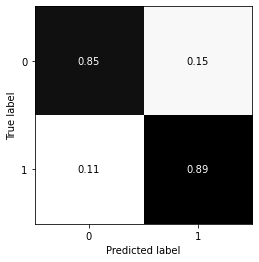

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=clf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

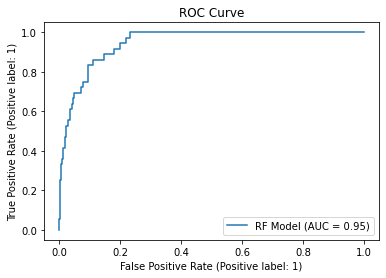

In [45]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="RF Model")
_ = display.ax_.set_title("ROC Curve")

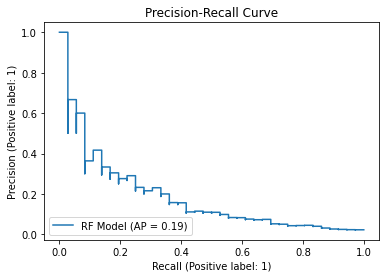

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

y_prob = clf.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob[:, 1], name="RF Model")
_ = display.ax_.set_title("Precision-Recall Curve")

#### Feature Importance

In [47]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, random_state=0)
pd.DataFrame(abs(result['importances_mean']),index=X_train.columns).sort_values(0, ascending=False)

,0
communitySize,0.106074
partOfCommunity,0.096750
sharedIdsDegree,0.017765
p2pSharedCardPageRank,0.017276
ipDegree,0.008620
cardDegree,0.004306
deviceDegree,0.002557
p2pReceivedWeightedPageRank,0.002438
p2pSentPageRank,0.001482
p2pReceivedWeightedDegree,0.001460


## Clean Up
This section will help clean all the additional graph elements and properties created in the above workflow.

In [49]:
# delete created relationships
run(driver,'MATCH (:User)-[r:SHARED_IDS]->() DELETE r')
run(driver,'MATCH (:User)-[r:P2P_WITH_SHARED_CARD]->() DELETE r')
run(driver,'MATCH (:User)-[r:SIMILAR_IDS]->() DELETE r')

[]

In [50]:
# remove created node Labels
run(driver,'MATCH (u:FlaggedUser) REMOVE u:FlaggedUser')
run(driver,'MATCH (u:FraudUser) REMOVE u:FraudRiskUser')
run(driver,'MATCH (u:FraudUser) REMOVE u:FraudSharedId')

[]

In [51]:
run(driver,'''
    MATCH (n)
    REMOVE n.wccId,
        n.sharedIdsDegree,
        n.partOfCommunity,
        n.p2pSharedCardPageRank,
        n.p2pSharedCardDegree,
        n.p2pSentWeightedPageRank,
        n.p2pSentWeightedDegree,
        n.p2pSentPageRank,
        n.p2pSentDegree,
        n.p2pReversedSharedCardPageRank,
        n.p2pReversedSharedCardDegree,
        n.p2pReceivedWeightedPageRank,
        n.p2pReceivedWeightedDegree,
        n.p2pReceivedPageRank,
        n.p2pReceivedDegree,
        n.louvainCommunityId,
        n.ipDegree,
        n.fraudRiskRatio,
        n.fraudRiskDegree,
        n.fraudRisk,
        n.flaggedRatio,
        n.flaggedDegree,
        n.deviceDegree,
        n.degree,
        n.communitySize,
        n.cardDegree
''')

[]

In [52]:
run(driver, 'MATCH ()-[r]->() REMOVE r.inverseDegreeWeight')

[]

In [53]:
clear_all_graphs(driver)